In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary
import torchvision
from glob import glob
import random
import pandas as pd
from PIL import Image
from helper_functions import walk_through_dir, plot_loss_curves, set_seeds
from helper_functions import pred_and_plot_image
from going_modular.model_builder import Net
from going_modular.data_setup import create_dataloaders
from going_modular.engine import train, test_step
from going_modular.utils import save_model
import timm


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# get device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# get data location
data_path = "./dataset/chest_xray/"
walk_through_dir(data_path)

There are 3 directories and 0 images in './dataset/chest_xray/'.
There are 2 directories and 0 images in './dataset/chest_xray/test'.
There are 0 directories and 234 images in './dataset/chest_xray/test/NORMAL'.
There are 0 directories and 390 images in './dataset/chest_xray/test/PNEUMONIA'.
There are 2 directories and 0 images in './dataset/chest_xray/train'.
There are 0 directories and 1341 images in './dataset/chest_xray/train/NORMAL'.
There are 0 directories and 3875 images in './dataset/chest_xray/train/PNEUMONIA'.
There are 2 directories and 0 images in './dataset/chest_xray/val'.
There are 0 directories and 8 images in './dataset/chest_xray/val/NORMAL'.
There are 0 directories and 8 images in './dataset/chest_xray/val/PNEUMONIA'.


Random image path: NORMAL
Image class: train
Image shape (1642, 1680)


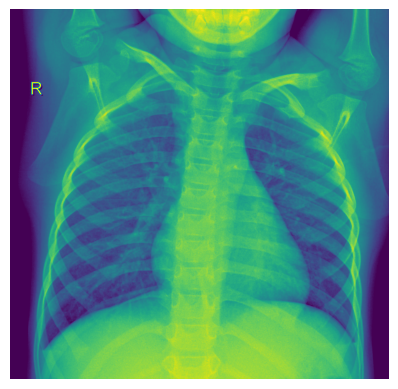

In [5]:
# get all images
image_path_list = list(glob(data_path +"*/*/*.jpeg"))

# pick a random image
random_image_path = random.choice(image_path_list)

# parent file and parent image
parent = os.path.dirname(random_image_path)

# open image 
img = Image.open(random_image_path)

# view with plt
img_plt = np.asarray(img)
plt.imshow(img_plt)
print(f"Random image path: {parent.split('/')[4]}")
print(f"Image class: {parent.split('/')[3]}")
print(f"Image shape {img_plt.shape}")
plt.axis(False);

In [6]:
# tranform 
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225]) ])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225]) ])


In [7]:
# getting train and test data loader in place
train_dir = data_path + "train/"
test_dir = data_path + "test/"
val_dir = data_path + "val/"

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, 
    train_transform=train_transform, test_trainsform=test_transform,
    train_batch_size=16, test_batch_size=1)


# alone validation data
val_data = torchvision.datasets.ImageFolder(root=val_dir, transform=test_transform)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=False, pin_memory=True)

print(class_names)
print(f'Number of train images: {len(train_dataloader)} for batch')
print(f'Number of test images: {len(test_dataloader)} for batch')
print(f'Number of test images: {len(val_dataloader)} for batch')

['NORMAL', 'PNEUMONIA']
Number of train images: 326 for batch
Number of test images: 624 for batch
Number of test images: 16 for batch


In [8]:
# model summary
set_seeds()
model = Net().to(device)
#summary(model=model, input_size=(1,3,224,224),col_names=["trainable"])


In [9]:
# loss & optimizer 
loss_fn = nn.functional.nll_loss
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
my_scheaduler = StepLR(optimizer, step_size=6, gamma=0.5)

In [10]:
# set_seeds()
# NUM_EPOCHS = 15

# model_0_results = train(model=model,  train_dataloader=train_dataloader,
#                         test_dataloader=test_dataloader, optimizer=optimizer,
#                         loss_fn=loss_fn, epochs=NUM_EPOCHS, device=device,
#                         my_scheaduler=my_scheaduler)

In [11]:
# model_0_df = pd.DataFrame(model_0_results)
# model_0_df

In [12]:
# plot_loss_curves(model_0_results)

In [13]:
## save model
# save_model(model=model,model_name="model_0.pth",target_dir="save_model",)


In [14]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_0 = Net()

# Load model state dict 
loaded_model_0.load_state_dict(torch.load("./save_model/model_0.pth"))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_0.to(device)

summary(model=loaded_model_0, input_size=(1,3,224,224),col_names=["input_size", "output_size", "trainable"])

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831440/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Input Shape               Output Shape              Trainable
Net                                      [1, 3, 224, 224]          [1, 2]                    True
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 8, 222, 222]          True
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 8, 222, 222]          True
│    └─ReLU: 2-2                         [1, 8, 222, 222]          [1, 8, 222, 222]          --
│    └─BatchNorm2d: 2-3                  [1, 8, 222, 222]          [1, 8, 222, 222]          True
├─MaxPool2d: 1-2                         [1, 8, 222, 222]          [1, 8, 111, 111]          --
├─Sequential: 1-3                        [1, 8, 111, 111]          [1, 16, 109, 109]         True
│    └─Conv2d: 2-4                       [1, 8, 111, 111]          [1, 16, 109, 109]         True
│    └─ReLU: 2-5                         [1, 16, 109, 109]         [1, 16, 109, 109]         --
│    └─BatchNorm2d: 2

## Check validation

Random image path: NORMAL


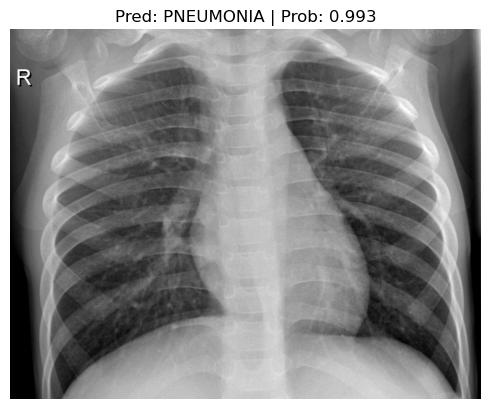

In [15]:
# get all images
image_path_list = list(glob(data_path +"test/*/*.jpeg"))
random_image_path = random.choice(image_path_list)

pred_and_plot_image(image_path=random_image_path, class_names=class_names, model= loaded_model_0)
print(f"Random image path: {parent.split('/')[4]}")


In [16]:
# with data validation
test_step(dataloader=val_dataloader, device=device, loss_fn=loss_fn, model=model)

(0.6931522525846958, 0.5)

### used effi and chest x

In [17]:
# Download model
model_xception = timm.create_model('xception', pretrained=True).to(device)
model_xception


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [18]:
model_xception.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [19]:
# update classifier model
## Freezing the base model and change the output layer
for param in model_xception.parameters():
    param.requires_grad = False

# Reemplazar el último layer con un nuevo layer de salida con 2 clases
model_xception.fc = nn.Linear(2048, len(class_names), bias=True)

# Mover el modelo a la GPU si está disponible
model_xception = model_xception.to(device)

In [20]:
summary(model=model_xception, input_size=(1,3,224,224),col_names=["input_size", "output_size", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Trainable
Xception                                 [1, 3, 224, 224]          [1, 2]                    Partial
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 32, 111, 111]         False
├─BatchNorm2d: 1-2                       [1, 32, 111, 111]         [1, 32, 111, 111]         False
├─ReLU: 1-3                              [1, 32, 111, 111]         [1, 32, 111, 111]         --
├─Conv2d: 1-4                            [1, 32, 111, 111]         [1, 64, 109, 109]         False
├─BatchNorm2d: 1-5                       [1, 64, 109, 109]         [1, 64, 109, 109]         False
├─ReLU: 1-6                              [1, 64, 109, 109]         [1, 64, 109, 109]         --
├─Block: 1-7                             [1, 64, 109, 109]         [1, 128, 55, 55]          False
│    └─Sequential: 2-1                   [1, 64, 109, 109]         [1, 128, 55, 55]          False
│    │    

In [22]:
# run model xception
NUM_EPOCHS = 15

model_1_results = train(model=model_xception,  train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader, optimizer=optimizer,
                        loss_fn=loss_fn, epochs=NUM_EPOCHS, device=device,
                        my_scheaduler=my_scheaduler)

  7%|▋         | 1/15 [01:20<18:45, 80.42s/it]

Epoch: 1 | train_loss: -0.0585 | train_acc: 0.5316 | test_loss: -0.0741 | test_acc: 0.5304


 13%|█▎        | 2/15 [02:41<17:27, 80.62s/it]

Epoch: 2 | train_loss: -0.0609 | train_acc: 0.5491 | test_loss: -0.0930 | test_acc: 0.5369


 20%|██        | 3/15 [04:01<16:03, 80.29s/it]

Epoch: 3 | train_loss: -0.0593 | train_acc: 0.5343 | test_loss: -0.0828 | test_acc: 0.5497


 27%|██▋       | 4/15 [05:21<14:44, 80.39s/it]

Epoch: 4 | train_loss: -0.0591 | train_acc: 0.5355 | test_loss: -0.0832 | test_acc: 0.5208


 33%|███▎      | 5/15 [06:42<13:25, 80.51s/it]

Epoch: 5 | train_loss: -0.0594 | train_acc: 0.5408 | test_loss: -0.0683 | test_acc: 0.5128


 33%|███▎      | 5/15 [07:36<15:13, 91.34s/it]


KeyboardInterrupt: 

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))

base_model.trainable = False

model = Sequential()

model.add(base_model)

model.add(BatchNormalization())

model.add(Dropout(0.45)) 

model.add(Dense(220, activation='relu'))

model.add(Dropout(0.25)) 

model.add(Dense(60,activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Tengo este modelo escrito en tensorflow, utiliza la libreria de timm para descargar el modelo y reescribe el modelo en pytorch, el ultimo output del modelo es 1000, las imagenes son 256x256